Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

### Dataset

In [2]:
df = pd.read_csv('dataset_gabungan_fa.csv')

In [3]:
print("Data Info:")
print(df.head())
print(f"\nBentuk data: {df.shape}")
print(f"Kolom yang tersedia: {df.columns.tolist()}")

Data Info:
   No.                Judul Tanggal_Rilis   Tipe  Rating  \
0    1  Karate Kid: Legends    2025-05-08  Movie      72   
1    2      The Old Guard 2    2025-07-01  Movie      61   
2    3            Ballerina    2025-06-04  Movie      74   
3    4  Ice Road: Vengeance    2025-06-27  Movie      70   
4    5       Heads of State    2025-07-02  Movie      69   

                      Genre  Durasi  \
0  Action, Adventure, Drama  1h 34m   
1           Action, Fantasy  1h 47m   
2   Action, Thriller, Crime   2h 5m   
3   Action, Thriller, Drama  1h 53m   
4  Action, Thriller, Comedy  1h 53m   

                                            Overview   Kreator_Sutradara  
0  After a family tragedy, kung fu prodigy Li Fon...  Jonathan Entwistle  
1  Andy and her team of immortal warriors fight w...    Victoria Mahoney  
2  Taking place during the events of John Wick: C...         Len Wiseman  
3  Big rig ice road driver Mike McCann travels to...  Jonathan Hensleigh  
4  The UK Prime Mi

Missing value

In [4]:
# Identifikasi dan handling missing values
print("\nHandling missing value")
print("Missing values per kolom:")
print(df.isnull().sum())


Handling missing value
Missing values per kolom:
No.                     0
Judul                   0
Tanggal_Rilis           3
Tipe                    0
Rating                  0
Genre                  12
Durasi                138
Overview               65
Kreator_Sutradara    1415
dtype: int64


Bersihin data

In [5]:
print("Jumlah data kosong sebelum dibersihkan:")
print(df.isnull().sum())

# Tipe Teks
df['Genre'].fillna('Unknown', inplace=True)
df['Overview'].fillna('No description available', inplace=True)
df['Kreator_Sutradara'].fillna('Unknown', inplace=True)

# Tipe Angka (Numerik)
# fungsi konversi ke menit yang akurat sebelum normalisasi
def convert_to_minutes(durasi_str):
    if isinstance(durasi_str, str):
        durasi_str = durasi_str.lower()
        if 'h' in durasi_str and 'm' in durasi_str:
            parts = durasi_str.split('h')
            hours = int(parts[0]) if parts[0] else 0
            minutes_part = parts[1].replace('m', '').strip()
            minutes = int(minutes_part) if minutes_part else 0
            return hours * 60 + minutes
        elif 'h' in durasi_str:
            return int(durasi_str.replace('h', '').strip()) * 60
        elif 'm' in durasi_str:
            # Handle "Xm per episode" and "Xm"
            minutes_str = durasi_str.split('m')[0].strip()
            return int(minutes_str)
    # Jika sudah berupa angka (float/int) atau gagal konversi, kembalikan apa adanya atau 0
    if isinstance(durasi_str, (int, float)):
        return durasi_str
    return 0

df['Durasi'] = df['Durasi'].apply(convert_to_minutes)

# Isi NaN yang mungkin masih ada dengan median
df['Durasi'].fillna(df['Durasi'].median(), inplace=True)

# Tipe Tanggal
df.dropna(subset=['Tanggal_Rilis'], inplace=True)


# Verifikasi ulang untuk memastikan semua sudah bersih
print("\nData kosong SETELAH dibersihkan:")
print(df.isnull().sum())

Jumlah data kosong sebelum dibersihkan:
No.                     0
Judul                   0
Tanggal_Rilis           3
Tipe                    0
Rating                  0
Genre                  12
Durasi                138
Overview               65
Kreator_Sutradara    1415
dtype: int64

Data kosong SETELAH dibersihkan:
No.                  0
Judul                0
Tanggal_Rilis        0
Tipe                 0
Rating               0
Genre                0
Durasi               0
Overview             0
Kreator_Sutradara    0
dtype: int64


Format Rating

In [6]:
# Format Rating
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df.dropna(subset=['Rating'])

Normalisasi Rating

In [7]:
# Normalisasi Rating ke skala 0-10
if df['Rating'].max() > 10:
    df['Rating'] = df['Rating'] / 10.0

print(f"Data setelah dibersihkan: {df.shape}")
print(f"Rating range: {df['Rating'].min()} - {df['Rating'].max()}")

Data setelah dibersihkan: (4177, 9)
Rating range: 0.0 - 10.0


### Feature Engineering

Preprocessing TF-IDF

In [8]:
# Preprocessing Overview dengan TF-IDF
print("Membuat TF-IDF matrix untuk Overview...")
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=3000,  # Dikurangi untuk efisiensi
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

tfidf_matrix = tfidf.fit_transform(df['Overview'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

Membuat TF-IDF matrix untuk Overview...
TF-IDF matrix shape: (4177, 3000)


Preprocessing Genre dengan CountVectorizer

In [9]:
# Preprocessing Genre dengan CountVectorizer
print("Membuat Genre matrix...")
def genre_tokenizer(text):
    if not isinstance(text, str):
        return []
    # Bersihkan dan split genre
    genres = [genre.strip().lower() for genre in text.split(',')]
    return [genre for genre in genres if genre and genre != 'unknown']

genre_vectorizer = CountVectorizer(
    tokenizer=genre_tokenizer,
    binary=True  # Binary encoding untuk genre
)

genre_matrix = genre_vectorizer.fit_transform(df['Genre'])
print(f"Genre matrix shape: {genre_matrix.shape}")

Membuat Genre matrix...
Genre matrix shape: (4177, 24)


Feature tambahan

In [10]:
# Feature tambahan durasi
additional_features = []
if 'Durasi' in df.columns:
    # Normalisasi durasi
    durasi_normalized = pd.to_numeric(df['Durasi'], errors='coerce').fillna(0)
    durasi_normalized = (durasi_normalized - durasi_normalized.mean()) / durasi_normalized.std()
    additional_features.append(durasi_normalized.values.reshape(-1, 1))

# Fitur tambahan Tahun rilis
if 'Tanggal_Rilis' in df.columns:
    # Extract year dari tanggal
    df['Year'] = pd.to_datetime(df['Tanggal_Rilis'], errors='coerce').dt.year
    year_normalized = (df['Year'].fillna(df['Year'].median()) - df['Year'].min()) / (df['Year'].max() - df['Year'].min())
    additional_features.append(year_normalized.values.reshape(-1, 1))

Gabungin Feature

In [11]:
# Gabungin semua features
print("Menggabungkan semua features...")
combined_features = hstack([genre_matrix, tfidf_matrix])

if additional_features:
    additional_matrix = np.hstack(additional_features)
    combined_features = hstack([combined_features, csr_matrix(additional_matrix)])

print(f"Combined features shape: {combined_features.shape}")

Menggabungkan semua features...
Combined features shape: (4177, 3026)


### Persiapan data untuk Model

In [12]:
# Wide features (Genre + additional features)
X_wide = genre_matrix.toarray()
if additional_features:
    X_wide = np.hstack([X_wide, additional_matrix])

# Deep features (TF-IDF)
X_deep = tfidf_matrix.toarray()

# Target
y = df['Rating'].astype(np.float32)

print(f"Wide features shape: {X_wide.shape}")
print(f"Deep features shape: {X_deep.shape}")
print(f"Target shape: {y.shape}")

Wide features shape: (4177, 26)
Deep features shape: (4177, 3000)
Target shape: (4177,)


Split data

In [13]:
# Split data
X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test = train_test_split(
    X_wide, X_deep, y,
    test_size=0.2,
    random_state=42,
    stratify=pd.cut(y, bins=5)  # Stratified split berdasarkan rating
)

In [14]:
# Normalisasi features untuk Deep part
scaler = StandardScaler()
X_deep_train = scaler.fit_transform(X_deep_train)
X_deep_test = scaler.transform(X_deep_test)

print(f"\nData training - Wide: {X_wide_train.shape}, Deep: {X_deep_train.shape}")
print(f"Data testing - Wide: {X_wide_test.shape}, Deep: {X_deep_test.shape}")


Data training - Wide: (3341, 26), Deep: (3341, 3000)
Data testing - Wide: (836, 26), Deep: (836, 3000)


### Membuat model Wide & Deep

In [15]:
# Input layers
wide_input = Input(shape=(X_wide.shape[1],), name='wide_input')
deep_input = Input(shape=(X_deep.shape[1],), name='deep_input')

# Wide path (Linear model)
wide_path = Dense(1, name='wide_path')(wide_input)

# Deep path (Neural Network)
deep_path = Dense(512, activation='relu', name='deep_1')(deep_input)
deep_path = BatchNormalization()(deep_path)
deep_path = Dropout(0.3)(deep_path)

deep_path = Dense(256, activation='relu', name='deep_2')(deep_path)
deep_path = BatchNormalization()(deep_path)
deep_path = Dropout(0.2)(deep_path)

deep_path = Dense(128, activation='relu', name='deep_3')(deep_path)
deep_path = Dropout(0.1)(deep_path)

deep_path = Dense(64, activation='relu', name='deep_4')(deep_path)

# Combine Wide & Deep
combined = concatenate([wide_path, deep_path], name='combined')

# Output layer
output = Dense(1, activation='linear', name='output')(combined)

# Create model
model = Model(inputs=[wide_input, deep_input], outputs=output)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print("Model architecture:")
model.summary()

Model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ deep_input          │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_1 (Dense)      │ (None, 512)       │  1,536,512 │ deep_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ deep_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_2 (Dense)      │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ deep_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_3 (Dense)      │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_input          │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ deep_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_path (Dense)   │ (None, 1)         │         27 │ wide_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_4 (Dense)      │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined            │ (None, 65)        │          0 │ wide_path[0][0],  │
│ (Concatenate)       │                   │            │ deep_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         66 │ combined[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,712,157 (6.53 MB)

 Trainable params: 1,710,621 (6.53 MB)

 Non-trainable params: 1,536 (6.00 KB)

### Training Model

In [16]:
# Callbacks untuk training yang lebih baik
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

In [17]:
# Training
history = model.fit(
    x=[X_wide_train, X_deep_train],
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=([X_wide_test, X_deep_test], y_test),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining selesai!")

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 17.5710 - mae: 3.4750 - mse: 17.5710 - val_loss: 12.9345 - val_mae: 3.3930 - val_mse: 12.9345 - learning_rate: 0.0010
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 2.7330 - mae: 1.1936 - mse: 2.7330 - val_loss: 10.9146 - val_mae: 3.0907 - val_mse: 10.9146 - learning_rate: 0.0010
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.0593 - mae: 1.0452 - mse: 2.0593 - val_loss: 7.8667 - val_mae: 2.5481 - val_mse: 7.8667 - learning_rate: 0.0010
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.7686 - mae: 0.9700 - mse: 1.7686 - val_loss: 5.8559 - val_mae: 2.1167 - val_mse: 5.8559 - learning_rate: 0.0010
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.5640 - mae: 0.9053 - mse: 1.5640 - val_loss: 4.8315 - val_mae: 1.8343 - val_mse: 4.8315 - learning_rate: 0.0010
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.5135 - mae: 0.8999 - mse: 1.5135 - val_loss: 3.9851 - val_mae:

### Evaluasi Model

Test Loss (MSE): 2.4775
Test MAE: 1.0774
Test RMSE: 1.5740
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


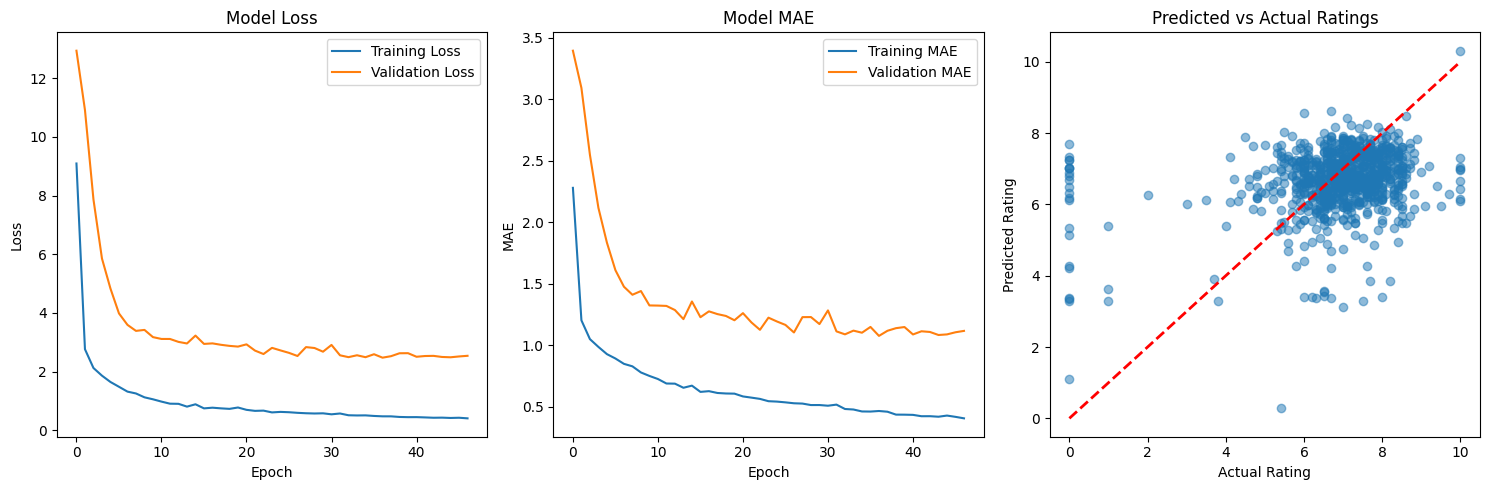

In [18]:
# Evaluasi pada test set
test_loss, test_mae, test_mse = model.evaluate([X_wide_test, X_deep_test], y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {np.sqrt(test_mse):.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)

# Prediksi vs Actual
y_pred = model.predict([X_wide_test, X_deep_test])
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs Actual Ratings')

plt.tight_layout()
plt.show()

Sistem Rekomendasi

In [19]:
def get_content_based_recommendations(title, top_n=10):
    try:
        # Cari index dari judul
        idx = df[df['Judul'].str.contains(title, case=False, na=False)].index[0]

        # Hitung cosine similarity
        target_vector = combined_features[idx]
        sim_scores = cosine_similarity(target_vector, combined_features)

        # Urutkan berdasarkan similarity
        sim_scores = list(enumerate(sim_scores[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Ambil top N (skip index 0)
        top_indices = [i[0] for i in sim_scores[1:top_n+1]]

        return df.iloc[top_indices]

    except IndexError:
        print(f"Judul '{title}' tidak ditemukan dalam dataset.")
        return pd.DataFrame()

In [20]:
def get_model_based_recommendations(top_n=10):
    # Prediksi untuk semua data
    X_wide_all = X_wide
    X_deep_all = scaler.transform(tfidf_matrix.toarray())

    predictions = model.predict([X_wide_all, X_deep_all])

    # Tambahkan prediksi ke dataframe
    df_temp = df.copy()
    df_temp['predicted_rating'] = predictions.flatten()

    # Clip prediksi ke range valid
    df_temp['predicted_rating'] = df_temp['predicted_rating'].clip(0, 10)

    # Urutkan berdasarkan prediksi
    recommendations = df_temp.sort_values('predicted_rating', ascending=False)

    return recommendations.head(top_n)

In [21]:
# Contoh penggunaan
print("\nContoh Rekomendasi")

# Content-based recommendation
sample_title = "Jurassic World Rebirth"
if sample_title in df['Judul'].values:
    print(f"\nRekomendasi Content-Based untuk '{sample_title}':")
    content_recs = get_content_based_recommendations(sample_title)
    print(content_recs[['Judul', 'Genre', 'Rating']].head())
else:
    print(f"'{sample_title}' tidak ditemukan, mencoba judul lain...")
    # Ambil judul pertama yang ada
    sample_title = df['Judul'].iloc[0]
    print(f"\nRekomendasi Content-Based untuk '{sample_title}':")
    content_recs = get_content_based_recommendations(sample_title)
    print(content_recs[['Judul', 'Genre', 'Rating']].head())

# Model-based recommendation
print("\nTop 10 Rekomendasi Berdasarkan Prediksi Model:")
model_recs = get_model_based_recommendations()
print(model_recs[['Judul', 'Genre', 'Rating', 'predicted_rating']].head(10))


Contoh Rekomendasi

Rekomendasi Content-Based untuk 'Jurassic World Rebirth':
                            Judul                               Genre  Rating
38        Jurassic World Dominion  Adventure, Action, Science Fiction     6.7
833                      Eternals  Science Fiction, Action, Adventure     6.8
851  Star Wars: The Force Awakens  Adventure, Action, Science Fiction     7.3
460    Captain America: Civil War  Adventure, Action, Science Fiction     7.4
362              The Tomorrow War  Action, Science Fiction, Adventure     7.5

Top 10 Rekomendasi Berdasarkan Prediksi Model:
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
                                                  Judul  \
3095                         PuraOre! ~Pride of Orange~   
2578                                         Cyborg 009   
438     Jurassic World Rebirth: The Making of a New Era   
2129  JUJUTSU KAISEN: Hidden Inventory / Premature D...   
75                                                Night   
2681      

In [22]:
# Simpan model
model.save('wide_deep_recommendation_model.h5')

# Simpan preprocessors
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(genre_vectorizer, 'genre_vectorizer.joblib')
joblib.dump(scaler, 'deep_scaler.joblib')

# Simpan dataset final
df.to_csv('processed_dataset.csv', index=False)

print("Semua file berhasil disimpan!")
print("\nFile yang disimpan:")
print("- wide_deep_recommendation_model.h5")
print("- tfidf_vectorizer.joblib")
print("- genre_vectorizer.joblib")
print("- deep_scaler.joblib")
print("- processed_dataset.csv")

Semua file berhasil disimpan!

File yang disimpan:
- wide_deep_recommendation_model.h5
- tfidf_vectorizer.joblib
- genre_vectorizer.joblib
- deep_scaler.joblib
- processed_dataset.csv
